# Векторизация, Numba

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. "Оптимизация выполнения кода, векторизация, Numba"
* https://numba.pydata.org/numba-doc/latest/user/5minguide.html
* https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types
* https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html
* https://numba.pydata.org/numba-doc/latest/user/vectorize.html


## Задачи для совместного разбора

1. Сгенерируйте массив `A` из `N=1млн` случайных целых чисел на отрезке от 0 до 1000. Пусть `B[i] = A[i] + 100`. Посчитайте среднее значение массива `B`. Ускорьте вычисления при помощи numba

In [2]:
import numpy as np
import numba

In [3]:
A = np.random.randint(0, 1000, size=(1000000,))

In [4]:
def f1(A):
    acc, cnt = 0, 0
    for x in A:
        acc += x + 100
        cnt += 1
    return acc / cnt

In [5]:
%%time
f1(A)

CPU times: total: 750 ms
Wall time: 750 ms


599.668572

In [6]:
@numba.njit
def f1_n(A):
    acc, cnt = 0, 0
    for x in A:
        acc += x + 100
        cnt += 1
    return acc / cnt

In [7]:
%%time
f1_n(A)

CPU times: total: 969 ms
Wall time: 1.28 s


599.668572

2. Напишите функцию, которая возвращает сумму всех чисел от 0 до x-1. Создайте массив, заполненный случайными целыми неотрицательными числами и примените функцию к каждому элементу массива.

In [23]:
def sum_range(x):
    return sum(range(x))

In [24]:
A = np.random.randint(0, 1000, size=(1000000,))

In [25]:
%%time
r = np.array([sum_range(a) for a in A])

CPU times: total: 18.1 s
Wall time: 18.2 s


In [11]:
@np.vectorize
def sum_range_vectorized(x):
    return sum(range(x))

In [12]:
%%time
sum_range_vectorized(A)

CPU times: total: 18.1 s
Wall time: 18.1 s


array([  2850,     10,   3570, ..., 131841, 418155,  57630])

In [26]:
@numba.vectorize(["int32(int32)"])
def sum_range_vectorized_nb(x):
    #return sum(range(x))
    return np.sum(np.arrange(x))

In [27]:
%%time
sum_range_vectorized_nb(A)

CPU times: total: 484 ms
Wall time: 496 ms


array([277140, 237016,  51360, ...,  21736, 456490,  50086], dtype=int64)

3. Приведите все слова из столбца key к верхнему регистру

In [5]:
import pandas as pd
import string
import numpy as np

def create_df(allow_nan=False, N=2_000_000):
    df = pd.DataFrame(np.random.randint(0, 10, (N, 4)), columns=[f"col{i}" for i in range(4)])
    names = ["Apple",  "Banana",  "Apricot",  "Atemoya",  "Avocados",  "Blueberry",  "Blackcurrant",  "Ackee",  "Cranberry",  "Cantaloupe",  "Cherry",  "Black sapote/Chocolate pudding fruit",  "Dragonrfruit",  "Dates",  "Cherimoya",  "Buddha’s hand fruit",  "Finger Lime",  "Fig",  "Coconut",]
    if allow_nan:
        names.append(None)
    df["key"] = np.random.choice(names, N, replace=True)
    return df

In [34]:
df = create_df(allow_nan=False, N=2_000_000)

In [30]:
%%time
df["key"].map(str.upper)

CPU times: total: 688 ms
Wall time: 686 ms


0                                        CHERRY
1                                       APRICOT
2                                         DATES
3                                        BANANA
4                                         APPLE
                           ...                 
1999995                             FINGER LIME
1999996    BLACK SAPOTE/CHOCOLATE PUDDING FRUIT
1999997                                 ATEMOYA
1999998                                     FIG
1999999                              CANTALOUPE
Name: key, Length: 2000000, dtype: object

In [35]:
%%time
df["key"].str.upper()   # работает с None

CPU times: total: 1.47 s
Wall time: 1.46 s


0                        APPLE
1                       CHERRY
2                        DATES
3                      COCONUT
4          BUDDHA’S HAND FRUIT
                  ...         
1999995                COCONUT
1999996             CANTALOUPE
1999997             CANTALOUPE
1999998              CRANBERRY
1999999                  DATES
Name: key, Length: 2000000, dtype: object

4\. Для каждой строки рассчитайте разность между значениями col0 и col1, если в столбце col3 стоит четное число, и разность между col0 и col2 в противном случае.

In [36]:
df = create_df(allow_nan=False, N=500_000).select_dtypes('number')

In [37]:
def process_row(row):
    if row["col3"] % 2 == 0:
        return row["col0"] - row["col1"]
    return row["col0"] - row["col2"]

In [41]:
%%time
df.apply(process_row, axis=1)

CPU times: total: 21 s
Wall time: 21.1 s


0         0
1        -9
2        -4
3        -1
4        -2
         ..
499995    3
499996   -4
499997   -2
499998   -3
499999   -7
Length: 500000, dtype: int32

In [40]:
%%time
pd.Series(np.where(
    df["col3"] % 2 == 0,
    df["col0"] - df["col1"],
    df["col0"] - df["col2"]
))

CPU times: total: 31.2 ms
Wall time: 17.5 ms


0         0
1        -9
2        -4
3        -1
4        -2
         ..
499995    3
499996   -4
499997   -2
499998   -3
499999   -7
Length: 500000, dtype: int32

## Лабораторная работа 2

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В файлах `recipes_sample.csv` и `reviews_sample.csv` (__ЛР 2__) находится информация об рецептах блюд и отзывах на эти рецепты соответственно. Загрузите данные из файлов в виде `pd.DataFrame` с названиями `recipes` и `reviews`. Обратите внимание на корректное считывание столбца(ов) с индексами. Приведите столбцы к нужным типам.

In [6]:
recipes = pd.read_csv('recipes_sample.csv')
reviews = pd.read_csv('reviews_sample.csv')

## Numba

В файле `rating_predictions.json` хранятся данные о рейтингах рецептов и прогнозных значениях рейтингов для этого рецепта, полученных при помощи модели машинного обучения. 

Напишите несколько версий функции (см. [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)) для расчета среднего абсолютного процентного отклонения значения рейтинга отзыва на рецепт от прогнозного значения рейтинга для данного рецепта. 


Замечание 1: в формуле MAPE под $A_t$ понимается рейтинг из отзыва $t$, под $F_t$ - прогнозное значения рейтинга отзыва $t$.

Замечание 2: в результате работы функций должно получиться одно число - MAPE для всего набора данных.

№1\.1 Создайте два списка `A_list` и `F_list` на основе файла `rating_predictions.json`. Напишите функцию `mape_lists` без использования векторизованных операций и методов массивов `numpy` и без использования `numba` (проитерируйтесь по спискам и вычислите суммарное значение MAPE для всех элементов, а потом усредните результат).

Измерьте время выполнения данной функции на входных данных `A_list` и `F_list`. Временем, затрачиваемым на создание списков, можно пренебречь.
    

In [2]:
import json
with open('rating_predictions.json', 'r', encoding='utf-8') as f: 
    text = json.load(f)

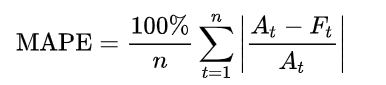

In [25]:
text[:3]

[{'rating': 5.0, 'prediction': 4.944444444444445},
 {'rating': 5.0, 'prediction': 4.4375},
 {'rating': 5.0, 'prediction': 4.7272727272727275}]

In [7]:
A_list = [text[i]['rating'] for i in range(len(text))]
F_list = [text[i]['prediction'] for i in range(len(text))]

In [17]:
def mape_lists(a, b):
    mape = 0
    for i in range(len(a)):
        mape += 1/len(a)*abs((a[i] - b[i])/a[i])
    return mape

In [18]:
%%time 
mape_lists(A_list, F_list)

CPU times: total: 46.9 ms
Wall time: 41.5 ms


0.13325265503995135

№1\.2. Создайте массивы `numpy` `A_array` и `F_array` на основе списков `A_list` и `F_list`. Напишите функцию `mape_numpy` с использованием векторизованных операций и методов массивов `numpy`.

Измерьте время выполнения данной функции на входных данных `A_array` и `F_array`. Временем, затрачиваемым на создание массивов, можно пренебречь.

In [14]:
A_array = np.array(A_list)
F_array = np.array(F_list)

In [19]:
def mape_numpy(a, b):
    mape = 1/len(a)*np.sum(np.abs((a-b)/a))
    return mape

In [20]:
%%time
mape_numpy(A_array, F_array)

CPU times: total: 0 ns
Wall time: 4.88 ms


0.13325265503991449

№1\.3. Создайте объекты `numba.typed.List` `A_typed` и `F_typed` на основе списков `A_list` и `F_list`. Напишите функцию `mape_numba` без использования векторизованных операций и методов массивов `numpy`, но с использованием `numba`. 

Измерьте время выполнения данной функции на входных данных `A_typed` и `F_typed`. Временем, затрачиваемым на создание объектов `numba.typed.List`, можно пренебречь.

Измерьте время выполнения данной функции на входных данных `A_array` и `F_array`.

In [41]:
A_typed = numba.typed.List(A_list)
F_typed = numba.typed.List(F_list)

In [42]:
@numba.njit
def mape_numba(a, b):
    mape = 0
    for i in range(len(a)):
        mape += 1/len(a)*abs((a[i] - b[i])/a[i])
    return mape

In [43]:
%%time
mape_numba(A_typed, F_typed)

CPU times: total: 219 ms
Wall time: 226 ms


0.13325265503995135

## Векторизация

Сайт-агрегатор устроил акцию: он дарит купоны на посещение ресторана тем пользователям, оставившим отзывы, идентификатор которых является _красивым числом_. Натуральное число называется _красивым_, если первая цифра числа совпадает с последней цифрой числа. 



№2\.1 Напишите функцию `is_pretty`, которая для каждого идентификатора пользователя из файла определяет, получит ли он подарок. Запрещается преобразовывать идентификатор пользователя к строке. Подтвердите корректность реализации, продемонстрировав примеры.

In [7]:
ids = reviews["user_id"].unique()
ids

array([     21752,     431813,     400708, ...,    1270706,    2282344,
       2000242659], dtype=int64)

In [21]:
def is_pretty(n: int) -> bool:
    a = np.trunc(np.log10(n))
    b = np.trunc(np.power(10, a))
    c = np.trunc(n / b)
    return n % 10 == c

In [22]:
is_pretty(ids[8]), is_pretty(ids[0])

(False, True)

№2\.2 Посчитайте с помощью функции `is_pretty` количество пользователей, которые получат подарок. Выведите это количество на экран. Измерьте время расчетов для входных данных `ids`.

In [210]:
#len(res[res == True])

4389

In [23]:
%%time 
k = 0
for i in range(len(ids)):
    if is_pretty(ids[i]):
        k += 1
k

CPU times: total: 469 ms
Wall time: 476 ms


4389

№2\.3. При помощи декоратора `numpy.vectorize` создайте векторизованную версию функции `is_pretty`. Корректно использовав эту векторизованную функцию, посчитайте количество пользователей, которые получат подарок. Выведите это количество на экран. Измерьте время расчетов для входных данных `ids`.


In [24]:
@np.vectorize
def is_pretty_np(n: int) -> bool:
    a = np.trunc(np.log10(n))
    b = np.trunc(np.power(10, a))
    c = np.trunc(n / b)
    return n % 10 == c

In [25]:
%%time
is_pretty_np(ids)

CPU times: total: 359 ms
Wall time: 364 ms


array([ True, False, False, ..., False, False, False])

№2\.4. При помощи декоратора `numba.vectorize` создайте векторизованную версию функции `is_pretty`. Корректно использовав эту векторизованную функцию, посчитайте количество пользователей, которые получат подарок. Выведите это количество на экран. Измерьте время расчетов для входных данных `ids`.


In [26]:
@numba.vectorize
def is_pretty_nb(n: int) -> bool:
    a = np.trunc(np.log10(n))
    b = np.trunc(np.power(10, a))
    c = np.trunc(n / b)
    return n % 10 == c

In [29]:
%%time
is_pretty_nb(ids)

CPU times: total: 0 ns
Wall time: 2.06 ms


array([ True, False, False, ..., False, False, False])